## 対応のある3標本以上の一元配置分散分析の事例

同じ母集団から無作為抽出された3つ以上の標本にてついて、標本平均が等しいかどうか？を検定する。

### (0)事前準備

In [3]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# scipy
from scipy import stats
# pingouin
import pingouin as pg
# statsmodels
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

### (0) テーマのためのデータセット

In [4]:
# pydatasetに用意されているPlantGrowthのデータセットを利用する
from pydataset import data
df = data("PlantGrowth")

print(df["group"].value_counts())
df.head()

group
ctrl    10
trt1    10
trt2    10
Name: count, dtype: int64


,weight,group
1,4.17,ctrl
2,5.58,ctrl
3,5.18,ctrl
4,6.11,ctrl
5,4.50,ctrl


In [5]:
# データセットの準備

# dataset 1, and 2 and 3 sample
values1 = df[df["group"]=="ctrl"]["weight"].values
values2 = df[df["group"]=="trt1"]["weight"].values
values3 = df[df["group"]=="trt2"]["weight"].values

values1, values2, values3

(array([4.17, 5.58, 5.18, 6.11, 4.5 , 4.61, 5.17, 4.53, 5.33, 5.14]),
 array([4.81, 4.17, 4.41, 3.59, 5.87, 3.83, 6.03, 4.89, 4.32, 4.69]),
 array([6.31, 5.12, 5.54, 5.5 , 5.37, 5.29, 4.92, 6.15, 5.8 , 5.26]))

### (0) データを確認

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


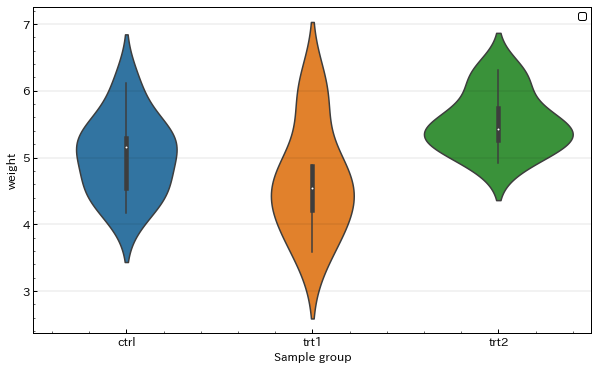

In [6]:
# ヴァイオリンプロット
fig, ax = plt.subplots(figsize=(10,6))

sns.violinplot(data=df, x="group", y="weight")
ax.set_xlabel("Sample group")
ax.set_ylabel("weight")
ax.legend()

### (0) 想定する分析シーン

- ある植物の成長を2つの異なる処理条件または全く処理されていない植物（対照群）の乾燥質量の記録を比べる。<br>
- それぞれの植物は対応ありとし、各インデックスが同じ植物と仮定する。
- それぞれの処理の結果質量の平均値に差があるといえるか？を統計的に検定する。<br>

### (1) 問題設定
- 帰無仮説$H_0$と対立仮説$H_1$を定義する。<br>

帰無仮説$H_0$：各因子で乾燥質量の平均値は変わらない。<br>
対立仮説$H_1$：乾燥質量の平均値が異なる。<br>

### (2) 適切な検定方法を選択する。
- 検定の目的、データの確認結果、サンプル数から適切な検定方法を選択する。<br>

1. 検定の目的<br>
-> 同一の母集団から、それぞれ3つの標本グループについて、その標本平均が等しいかどうか？を検定する。
-> 体形と運動行動(休憩、ウォーキング、ランニング)の2要因の組み合わせについて確認する。

2. データの確認 (ただし本分析においては仮定を置いたものとする。)<br>
    2-1. 正規性の仮定<br>
        -> 誤差が正規分布に従う。<br>
    2-2. 独立性の仮定<br>
        -> 観測値が互いに独立している。<br>
    2-3. 対称性の仮定<br>
        ->各群間の誤差の分散が等しいこと。これについてMauchlyのW検定を実施する。<br>

3. サンプル数の確認<br>
    サンプル数<br>
    各群サンプルが5以上、総サンプルが30以上。サンプル数としては少ないが、分布の平均値やばらつきは妥当性もって評価できると考えた。

*2-3の対称性の仮定の確認<br>

MauchlyのW検定<br>
被検体間で測定時感に関する分散が一定かどうかを検定する。方法論は、<br>
(1)データの共分散行列を求める。<br>
(2)共分散行列の固有値を求める<br>
(3)Wを計算する。Wは共分散行列の固有値の積<br>
(4)Wの自然対数を取った統計量とカイ二乗分布(自由度は群数-1)を用いて、p値を求める。<br>
(5)p値が事前に設定した優位水準より小さい場合、母分散が等しいという帰無仮説を棄却し、対称性が満たされていないと判断する。<br>

ここでは、上記計算をpingouin.sphericity()関数を用いて検定する。

In [7]:
data = pd.concat([
       pd.DataFrame({"idx":np.arange(len(values1)),
                     "Treatment":["ctrl" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"idx":np.arange(len(values2)),
                     "Treatment":["trt1" for i in range(len(values2))],
                     "Values":values2}),
       pd.DataFrame({"idx":np.arange(len(values3)),
                     "Treatment":["trt2" for i in range(len(values2))],
                     "Values":values3}),
       ]).sort_values(by=["idx", "Treatment"]).reset_index(drop=True)

mauchly_w = pg.sphericity(data, subject='idx', dv='Values', within='Treatment')
print(mauchly_w)

SpherResults(spher=True, W=0.8700054446419556, chi2=1.1140464731515662, dof=2, pval=0.5729119513868732)


MauchlyのW検定の結果、p値は5%より大きく対称性ありという帰無仮説を棄却できない。よって

### 検定方法：対応のある一元配置分散分析を利用する。

### (3) 優位水準を定義する。
- 優位と判断する水準を定義する。<br>

優位水準α=5%(両側)する。<br>

### (4) 検定統計量を計算する。
- 選択した検定方法に基づいて、検定統計量を計算する。<br>

方法1) 各統計量を求めつつ計算する。<br>

**F値の計算**

群間の平方和($SS_{Treatment}$) = $\sum_{i=1}^{k} n_i(\bar{Y}_{i\cdot} - \bar{Y}_{\cdot\cdot})^2$

被検体の平方和($SS_{Subject}$) = $\sum_{j=1}^{N} m(\bar{Y}_{\cdot j} - \bar{Y}_{\cdot\cdot})^2$

全体の平方和($SS_{Total}$) = $\sum_{i=1}^{k}\sum_{j=1}^{N} (Y_{ij} - \bar{Y}_{\cdot\cdot})^2$

残差平方和($SS_{Error}$) = $SS_{Total}$ - $SS_{Treatment}$ - $SS_{Subject}$

$df_{Treatment} = k - 1$

$df_{Subjects} = N - 1$

$df_{Error} = (k - 1)(N - 1)$

$MS_{Treatment} = \frac{SS_{Treatment}}{df_{Treatment}}$

$MS_{Subjects} = \frac{SS_{Subjects}}{df_{Subjects}}$

$MS_{Error} = \frac{SS_{Error}}{df_{Error}}$

$F = \frac{MS_{Treatment}}{MS_{Error}}$

**各変数**<br>

$k$: 群の数(処置レベルまたは条件の数)<br>

$n_i$: 各群のデータ数<br>

$\bar{Y}_{i\cdot}$: 各群の平均<br>

$\bar{Y}_{\cdot\cdot}$: 全体平均<br>

$N$: サンプル数<br>

$m$: 各被検体の測定回数<br>

$\bar{Y}_{\cdot j}$: 各被検体の平均<br>

$Y_{ij}$: 各データ点<br>

$SS_{Treatment}$: 群間平方和<br>

$SS_{Subjects}$: 被検体間平方和<br>

$SS_{Total}$: 全体の平方和<br>

$SS_{Error}$: 残差平方和<br>

$df_{Treatment}$: 群間の自由度<br>

$df_{Subjects}$: 被検体間の自由度<br>

$df_{Error}$: 残差の自由度<br>

$MS_{Treatment}$: 群間の平方平均<br>

$MS_{Subjects}$: 被検体間の平方平均<br>

$MS_{Error}$: 残差の平方平均<br>

$F$: F値（群間の平方平均と残差の平方平均の比）

In [8]:
# Function
def calc_Fvalue(values1:list, values2:list, values3:list)->float:
    '''
    F値を計算する

    Args
        values1 (list) : 因子1による結果の1次元リスト。numpy.arrayやpandas.Seriesも可
        values2 (list) : 因子2による結果の1次元リスト。numpy.arrayやpandas.Seriesも可
        values3 (list) : 因子3による結果の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        F : 計算されたF値を返す。
    '''

    data = pd.concat([
       pd.DataFrame({"idx":np.arange(len(values1)),
                     "Treatment":["ctrl" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"idx":np.arange(len(values2)),
                     "Treatment":["trt1" for i in range(len(values2))],
                     "Values":values2}),
       pd.DataFrame({"idx":np.arange(len(values3)),
                     "Treatment":["trt2" for i in range(len(values2))],
                     "Values":values3}),
       ]).sort_values(by=["idx", "Treatment"]).reset_index(drop=True)

    # calc mean
    m_t = data["Values"].mean()

    # data
    k = len(data["Treatment"].unique())
    N = len(data["idx"].unique())

    # calc SS_Total
    ss_tot = np.sum((data["Values"] - m_t)**2)
    # calc SS_Treatment
    ss_trt = N * np.sum((data.groupby("Treatment")["Values"].mean() - m_t)**2)
    # calc SS_Subject
    ss_sub = k * np.sum((data.groupby("idx")["Values"].mean() - m_t)**2)
    # calc SS_treatment
    ss_err = ss_tot - ss_trt - ss_sub

    # df
    df_trt = k - 1
    df_sub = N - 1
    df_err = df_trt * df_sub

    # F値
    ms_trt = ss_trt / df_trt
    ms_sub = ss_sub / df_sub
    ms_err = ss_err / df_err
    F = ms_trt / ms_err

    # print each value
    print(f"SS_treatment, SS_error : {ss_tot}, {ss_err}")
    print(f"df_treatment, df_error : {df_trt}, {df_err}")
    print(f"MS_treatment, MS_error : {ms_trt}, {ms_err}")
    print(f"F value : {F}")


    return df_trt, df_sub, F

In [9]:
# calculate t value
dfA, dfE, F = calc_Fvalue(values1=values1, values2=values2, values3=values3)

# 両側信頼係数のF値を求める。
# 片側優位水準
alpha = 0.05

# scipy.statsを使って計算する。
F_thre = stats.f.ppf(q=1 - alpha/2, dfn=dfA, dfd=dfE)
print(F_thre)

SS_treatment, SS_error : 14.258429999999999, 9.282526666666664
df_treatment, df_error : 2, 18
MS_treatment, MS_error : 1.8831700000000007, 0.5156959259259257
F value : 3.6517061805729645
5.714705386383056


2) statsmodels.stats.anova.AnovaRM()関数を使って計算する。

In [10]:
data = pd.concat([
       pd.DataFrame({"idx":np.arange(len(values1)),
                     "Treatment":["ctrl" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"idx":np.arange(len(values2)),
                     "Treatment":["trt1" for i in range(len(values2))],
                     "Values":values2}),
       pd.DataFrame({"idx":np.arange(len(values3)),
                     "Treatment":["trt2" for i in range(len(values2))],
                     "Values":values3}),
       ]).sort_values(by=["idx", "Treatment"]).reset_index(drop=True)

# AnovaRM
anova = AnovaRM(data, 'Values', 'idx', within=['Treatment'])
result = anova.fit()

anova_table = result.anova_table
anova_table

,F Value,Num DF,Den DF,Pr > F
Treatment,3.651706,2.0,18.0,0.046649


### (5) p値を計算する。
- 検定統計量に基づいてp値を計算する。<br>

In [11]:
print(anova_table["Pr > F"][0])

0.0466488248824482


### (6) 結果を解釈する。
- p値と優位水準を比較して結果を解釈する。<br>
p値≦$α$：帰無仮説を棄却し、対立仮説を採択する。<br>
p値>$α$：帰無仮説を棄却できない

### 判定
- p値0.0466で、優位水準5%より小さい。よって帰無仮説は棄却される。<br>
-> 差はある

### (7) 効果量を計算する。
- 検定の結果が優位であれば、効果量を計算し意義を評価する。<br>

方法) パーシャルイータ二乗$\eta_p^2$で計算する。

$\eta_p^2$ : 各要因と交互作用項が従属変数にどれだけの影響を与えるかを示す指標<br>

因子の効果量:<br>
$\eta_p^2 = \frac{SS_{treatment}}{SS_{treatment} + SS_{error}}$<br>

各変数は<br>
$\eta_p^2$: 因子のパーシャルイータ二乗<br>
$SS_{treatment}$: 因子の平方和<br>
$SS_{error}$: 残差の平方和<br>

$\eta_p^2$の値が大きいほど、効果量が大きいと判断する。<br>
効果量の大きさの目安は、

0.01: 小さい効果<br>
0.06: 中程度の効果<br>
0.14: 大きい効果<br>

In [12]:
# Function
def partial_eta_sq(values1:list, values2:list, values3:list)->float:
    '''
    partial eta squared値を計算する

    Args
        values1 (list) : 因子1による結果の1次元リスト。numpy.arrayやpandas.Seriesも可
        values2 (list) : 因子2による結果の1次元リスト。numpy.arrayやpandas.Seriesも可
        values3 (list) : 因子3による結果の1次元リスト。numpy.arrayやpandas.Seriesも可

    Return
        F : 計算されたF値を返す。
    '''

    data = pd.concat([
       pd.DataFrame({"idx":np.arange(len(values1)),
                     "Treatment":["ctrl" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"idx":np.arange(len(values2)),
                     "Treatment":["trt1" for i in range(len(values2))],
                     "Values":values2}),
       pd.DataFrame({"idx":np.arange(len(values3)),
                     "Treatment":["trt2" for i in range(len(values2))],
                     "Values":values3}),
       ]).sort_values(by=["idx", "Treatment"]).reset_index(drop=True)

    # calc mean
    m_t = data["Values"].mean()

    # data
    k = len(data["Treatment"].unique())
    N = len(data["idx"].unique())

    # calc SS_Total
    ss_tot = np.sum((data["Values"] - m_t)**2)
    # calc SS_Treatment
    ss_trt = N * np.sum((data.groupby("Treatment")["Values"].mean() - m_t)**2)
    # calc SS_Subject
    ss_sub = k * np.sum((data.groupby("idx")["Values"].mean() - m_t)**2)
    # calc SS_treatment
    ss_err = ss_tot - ss_trt - ss_sub

    # partial_eta_squared
    pes = ss_trt / (ss_trt + ss_err)

    # print each value
    print(f"SS_treatment, SS_error : {ss_tot}, {ss_err}")
    print(f"partial_eta_squared : {pes}")

    return pes

In [13]:
peta_squared = partial_eta_sq(values1, values2, values3)

SS_treatment, SS_error : 14.258429999999999, 9.282526666666664
partial_eta_squared : 0.28863349562925017


### 判定

$\eta_p^2$は0.29であり大きい効果。<br>